In [ ]:
import tensorflow as tf

In [ ]:
# example of semi-supervised gan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from keras.datasets.mnist import load_data
# from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
# tf.keras.optimizers.Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend

In [ ]:
print(tf. __version__)

2.8.2


In [ ]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

In [ ]:
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
	return d_model, c_model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load the images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

In [ ]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=1000, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=100):

	loss_C = []
	loss_d1 = []
	loss_d2 = []
	loss_G = []
	acc_C = []

	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))

		loss_C.append(c_loss)
		loss_d1.append(d_loss1)
		loss_d2.append(d_loss2)
		loss_G.append(g_loss)
		acc_C.append(c_acc*100)

		# evaluate the model performance every so often
		if (i+1) % (200 * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)
	return loss_C, loss_d1, loss_d2, loss_G, acc_C

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


In [ ]:
# train model
loss_C, loss_d1, loss_d2, loss_G, acc_C = train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(1000, 28, 28, 1) (1000,)
n_epochs=1, n_batch=100, 1/2=50, b/e=600, steps=600
>1, c[2.317,8], d[0.093,2.399], g[0.095]
>2, c[2.305,12], d[0.089,2.399], g[0.095]
>3, c[2.300,12], d[0.085,2.401], g[0.095]
>4, c[2.273,22], d[0.081,2.404], g[0.095]
>5, c[2.281,14], d[0.078,2.406], g[0.095]
>6, c[2.262,16], d[0.078,2.404], g[0.096]
>7, c[2.264,16], d[0.078,2.395], g[0.097]
>8, c[2.214,26], d[0.081,2.381], g[0.098]
>9, c[2.203,36], d[0.078,2.372], g[0.100]
>10, c[2.161,22], d[0.077,2.367], g[0.100]
>11, c[2.201,22], d[0.076,2.373], g[0.099]
>12, c[2.262,16], d[0.068,2.388], g[0.097]
>13, c[2.309,20], d[0.060,2.402], g[0.097]
>14, c[2.217,22], d[0.055,2.385], g[0.100]
>15, c[2.229,24], d[0.048,2.339], g[0.106]
>16, c[2.174,18], d[0.041,2.299], g[0.111]
>17, c[2.067,32], d[0.033,2.285], g[0.112]
>18, c[2.050,38], d[0.025,2.281], g[0.111]
>19, c[2.104,26], d[0.020,2.282], g[0.112]
>20, c[1.953,36], d[0.016,2.283], g[0.116]
>21, c[1.903,34], d[0.020,2.263], g[0.127]
>22, c[1.913,30], d[0.038,2.1

In [ ]:
import matplotlib.pyplot as plt

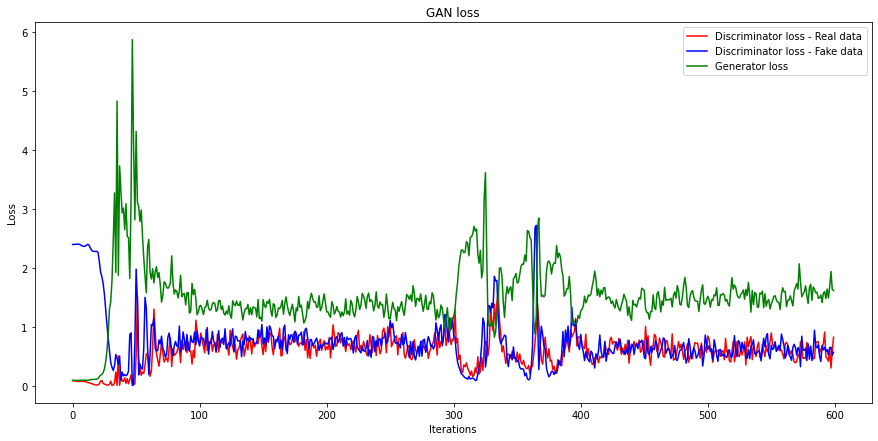

In [ ]:
epochs_range = range(0,600)
epochs = 600
# loss_C, loss_d1, loss_d2, loss_G, acc_C
# from matplotlib.pyplot import figure

# figure(figsize=(8, 6), dpi=80)
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(epochs_range, loss_d1[:epochs], 'r', label='Discriminator loss - Real data')
plt.plot(epochs_range, loss_d2[:epochs], 'b', label='Discriminator loss - Fake data')
plt.plot(epochs_range, loss_G[:epochs], 'g', label='Generator loss')
plt.title('GAN loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

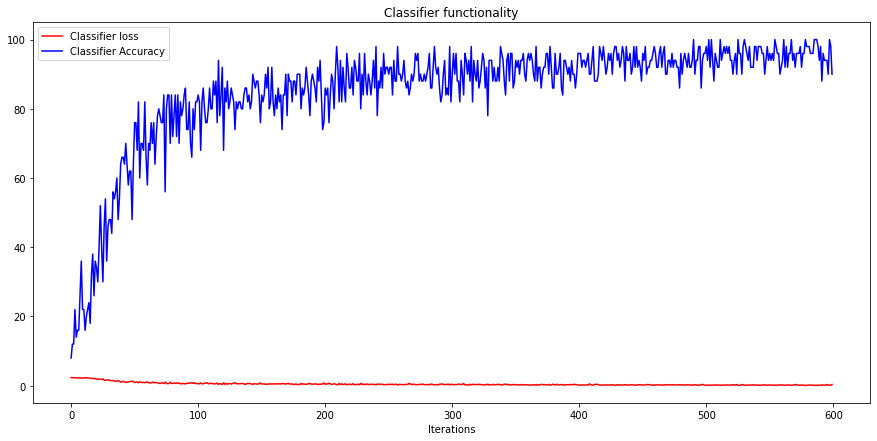

In [ ]:
epochs_range = range(0,600)
epochs = 600
# loss_C, loss_d1, loss_d2, loss_G, acc_C
# from matplotlib.pyplot import figure

# figure(figsize=(8, 6), dpi=80)
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(epochs_range, loss_C[:epochs], 'r', label='Classifier loss')
plt.plot(epochs_range, acc_C[:epochs], 'b', label='Classifier Accuracy')
plt.title('Classifier functionality')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('c_model_0600.h5')

In [ ]:
# load the dataset
(trainX, trainy), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)
# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 93.218%
Test Accuracy: 94.010%


#Part 2

In [ ]:
def train_without_GAN(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=100):

	loss_C = []
	acc_C = []

	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		# [X_real, _], y_real = generate_real_samples(dataset, half_batch)
		# d_loss1 = d_model.train_on_batch(X_real, y_real)
		# X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		# X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		# g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		# print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		print('>%d, c[%.3f,%.0f]' % (i+1, c_loss, c_acc*100))
	
		loss_C.append(c_loss)
		acc_C.append(c_acc*100)
	
    # print('>%d, c[%.3f,%.0f]' % (i+1, c_loss, c_acc*100))
		# evaluate the model performance every so often
		if (i+1) % (200 * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)
	 
	return loss_C, acc_C

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

(60000, 28, 28, 1) (60000,)


In [ ]:
loss_C, acc_C = train_without_GAN(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(1000, 28, 28, 1) (1000,)
n_epochs=1, n_batch=100, 1/2=50, b/e=600, steps=600
>1, c[2.309,6]
>2, c[2.296,14]
>3, c[2.299,12]
>4, c[2.281,12]
>5, c[2.269,20]
>6, c[2.257,20]
>7, c[2.296,12]
>8, c[2.273,18]
>9, c[2.228,36]
>10, c[2.274,16]
>11, c[2.272,14]
>12, c[2.225,34]
>13, c[2.237,32]
>14, c[2.268,18]
>15, c[2.200,42]
>16, c[2.228,24]
>17, c[2.204,36]
>18, c[2.190,20]
>19, c[2.144,46]
>20, c[2.153,28]
>21, c[2.131,44]
>22, c[2.094,36]
>23, c[2.106,36]
>24, c[2.077,40]
>25, c[2.073,42]
>26, c[2.008,46]
>27, c[2.040,50]
>28, c[1.973,70]
>29, c[1.943,54]
>30, c[1.904,50]
>31, c[1.940,50]
>32, c[1.870,54]
>33, c[1.739,70]
>34, c[1.783,50]
>35, c[1.654,64]
>36, c[1.695,62]
>37, c[1.680,60]
>38, c[1.531,70]
>39, c[1.593,66]
>40, c[1.584,64]
>41, c[1.535,62]
>42, c[1.471,58]
>43, c[1.515,56]
>44, c[1.221,72]
>45, c[1.322,62]
>46, c[1.418,48]
>47, c[1.127,72]
>48, c[1.120,74]
>49, c[1.018,80]
>50, c[1.085,74]
>51, c[0.872,86]
>52, c[1.059,72]
>53, c[1.013,74]
>54, c[1.019,70]
>55, c[0.739,8

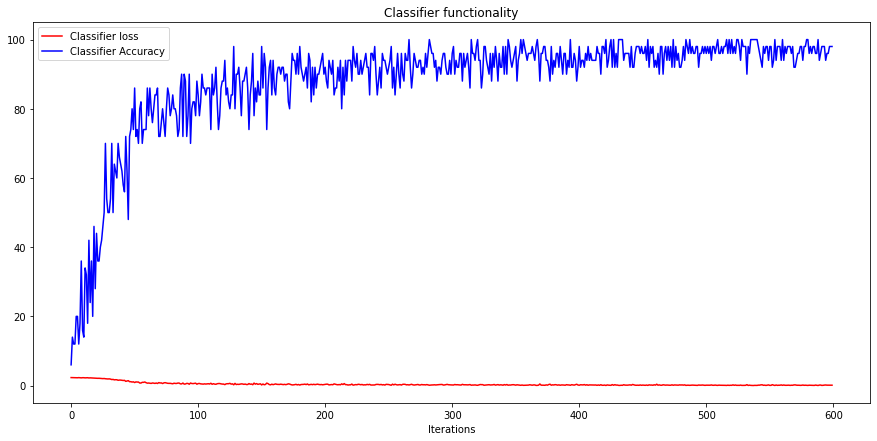

In [ ]:
epochs_range = range(0,600)
epochs = 600
# loss_C, loss_d1, loss_d2, loss_G, acc_C
# from matplotlib.pyplot import figure

# figure(figsize=(8, 6), dpi=80)
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(epochs_range, loss_C[:epochs], 'r', label='Classifier loss')
plt.plot(epochs_range, acc_C[:epochs], 'b', label='Classifier Accuracy')
plt.title('Classifier functionality')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
model = load_model('c_model_0600.h5')

In [ ]:
# load the dataset
(trainX, trainy), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)
# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 91.163%
Test Accuracy: 91.920%


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()

In [ ]:
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0   

In [ ]:
c_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [ ]:
g_model = define_generator(latent_dim)

In [ ]:
g_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

In [ ]:
gan_model = define_gan(g_model, d_model)

In [ ]:
gan_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           